### Intente hacer un agente que pueda pedir mas docs, lo hice malardo XD


In [22]:
#segmentacion de docs
from langchain_community.document_loaders import TextLoader
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter

#Vector store
import sqlite3
from langchain_community.vectorstores import SQLiteVec


# llms
from langchain_openai import ChatOpenAI
from langchain_huggingface import HuggingFaceEmbeddings

#Langgraph modules
from langchain_core.prompts import PromptTemplate

# python common modules
from IPython.display import Image, display
from typing_extensions import List
from typing import Literal
from dotenv import load_dotenv
from pathlib import Path

import os

load_dotenv()
#

base_dir = Path.cwd()
leyes_dir = base_dir / "leyes"  # Adjust this path based on your actual directory structure

# If leyes_dir doesn't exist, try going up one level
if not leyes_dir.exists():
    leyes_dir = base_dir.parent / "leyes"
    
retrieve_limit = 1

Cargamos el modelo

In [23]:
openai_api_key = os.getenv("DEEPSEEK_API_KEY")
openai_base_url = os.getenv("DEEPSEEK_API_URL")
openai_model = os.getenv("LLM_MODEL")

# Crear una instancia del modelo ChatOpenAI
llm = ChatOpenAI(
    # base_url=openai_base_url,
    # api_key=openai_api_key,
    model= "gpt-4o",
    temperature=0.5, 
)

Definir base de datos

In [24]:
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")  

Herramienta Recuperadora de docs

In [25]:
from langchain_core.tools import tool

numero_docs_recuperados: int  = 3

@tool(response_format="content_and_artifact")
def recuperarDocs(query: str):
    """Retrieve information related to a query."""
    # Create a new connection each time the function is called
    db_path_str = str(base_dir / "Database/leyes.db")
    
    # Create a new vector store with a new connection
    vector_store = SQLiteVec(
    table="leyes",
    connection=None,
    embedding=embeddings,
    db_file=db_path_str,
    )   

    retrieved_docs = vector_store.similarity_search(query, k=numero_docs_recuperados)
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\n" f"Content: {doc.page_content}")
        for doc in retrieved_docs
    )
    return serialized, retrieved_docs

tools = [recuperarDocs]

### Definimos el objetpo estado que será pasado entre nodos para añadir mensajes

In [26]:
from typing import Annotated, Sequence
from typing_extensions import TypedDict

from langchain_core.messages import BaseMessage

from langgraph.graph.message import add_messages


class AgentState(TypedDict):
    # The add_messages function defines how an update should be processed
    # Default is to replace. add_messages says "append"
    messages: Annotated[Sequence[BaseMessage], add_messages]

### Definimos el Edge condicional (arista entre los grafos) para ver si los documentos son suficientes o se necesita rewrite la pregunta

In [30]:

from typing import Annotated, Literal, Sequence
from typing_extensions import TypedDict

from langchain import hub
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_openai import ChatOpenAI

from pydantic import BaseModel, Field


from langgraph.prebuilt import tools_condition

### Edges


def grade_documents(state) -> Literal["generate", "rewrite"]:
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (messages): The current state

    Returns:
        str: A decision for whether the documents are relevant or not
    """

    print("---CHECK RELEVANCE---")

    # Data model
    class grade(BaseModel):
        """Binary score for relevance check."""

        binary_score: str = Field(description="Relevance score 'yes' or 'no'")

    # LLM
    model = ChatOpenAI(temperature=0, model="gpt-4o", streaming=True)

    # LLM with tool and validation
    llm_with_tool = model.with_structured_output(grade)

    # Prompt
    prompt = PromptTemplate(
        template="""You are a grader assessing relevance of a retrieved document to a user question. \n 
        Here is the retrieved document: \n\n {context} \n\n
        Here is the user question: {question} \n
        If the document contains keyword(s) or semantic meaning related to the user question AND could solve it, grade it as relevant. \n
        Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.""",
        input_variables=["context", "question"],
    )

    # Chain
    chain = prompt | llm_with_tool

    messages = state["messages"]
    last_message = messages[-1]

    question = messages[0].content
    docs = last_message.content

    scored_result = chain.invoke({"question": question, "context": docs})

    score = scored_result.binary_score

    if score == "yes":
        print("---DECISION: DOCS RELEVANT---")
        return "generate"

    else:
        print("---DECISION: DOCS NOT RELEVANT---")
        print(score)
        return "rewrite"


### Nodes
import json
from pathlib import Path

def pre_rewrite(state):
    """
    Pre-processing step to transform the query before retrieval.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with re-phrased question
    """
    print("---PRE-REWRITE---")
    messages = state["messages"]
    question = messages[0].content

    # Load the synonyms from the JSON file
    with open(Path.cwd() / "categorias_sinonimos_bolivia.json", "r", encoding="utf-8") as f:
        synonyms = json.load(f)
    print(synonyms)

    # Create a mapping of colloquial terms to standardized terms
    colloquial_to_standard = {}
    for category, terms in synonyms.items():
        standard_term = category.split(" / ")[0].lower()  # Use the category name as the standard term
        for term in terms:
            colloquial_to_standard[term.lower()] = standard_term

    # Replace colloquialisms in the question
    import re

    words = re.findall(r'\b\w+\b', question)
    standardized_words = [
        colloquial_to_standard.get(word.lower(), word) for word in words
    ]
    standardized_question = " ".join(standardized_words)

    print(f"Original question: {question}")
    print(f"Standardized question: {standardized_question}")

    # Update the state with the standardized question
    return {"messages": [HumanMessage(content=standardized_question)]}

def agent(state):
    """
    Invokes the agent model to generate a response based on the current state. Given
    the question, it will decide to retrieve using the retriever tool, or simply end.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with the agent response appended to messages
    """
    print("---CALL AGENT---")
    messages = state["messages"]
    model = ChatOpenAI(temperature=0, streaming=True, model="gpt-4-turbo")
    model = model.bind_tools(tools)
    response = model.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}


def rewrite(state):
    """
    Transform the query to produce a better question.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with re-phrased question
    """

    print("---TRANSFORM QUERY---")
    messages = state["messages"]
    question = messages[0].content

    msg = [
        HumanMessage(
            content=f""" \n 
    Look at the input and try to reason about the underlying semantic intent / meaning. \n 
    Here is the initial question:
    \n ------- \n
    {question} 
    \n ------- \n
    Formulate an improved question: """,
        )
    ]

    # Grader
    model = ChatOpenAI(temperature=0, model="gpt-4-0125-preview", streaming=True)
    response = model.invoke(msg)
    return {"messages": [response]}


def generate(state):
    """
    Generate answer

    Args:
        state (messages): The current state

    Returns:
         dict: The updated state with re-phrased question
    """
    print("---GENERATE---")
    messages = state["messages"]
    question = messages[1].content
    last_message = messages[-1]

    docs = last_message.content

    # Prompt
    prompt = hub.pull("rlm/rag-prompt")

    # LLM
    llm = ChatOpenAI(model_name="gpt-4o-mini", temperature=0, streaming=True)

    # Post-processing
    def format_docs(docs):
        return "\n\n".join(doc.page_content for doc in docs)

    # Chain
    rag_chain = prompt | llm | StrOutputParser()

    # Run
    response = rag_chain.invoke({"context": docs, "question": question})
    return {"messages": [response]}

Grafo

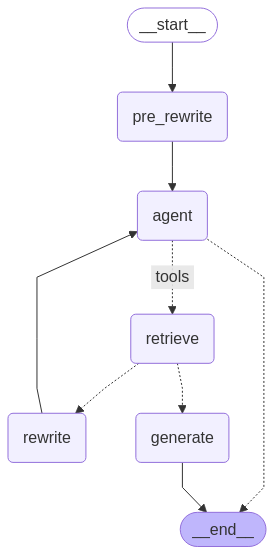

In [31]:
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode

# Define a new graph
workflow = StateGraph(AgentState)

# Define the nodes we will cycle between
workflow.add_node("pre_rewrite", pre_rewrite)  # Start node
workflow.add_node("agent", agent)  # agent
retrieve = ToolNode([recuperarDocs])
workflow.add_node("retrieve", retrieve)  # retrieval
workflow.add_node("rewrite", rewrite)  # Re-writing the question
workflow.add_node(
    "generate", generate
)  # Generating a response after we know the documents are relevant
# Call agent node to decide to retrieve or not
workflow.add_edge(START, "pre_rewrite")
workflow.add_edge("pre_rewrite", "agent")

# Decide whether to retrieve
workflow.add_conditional_edges(
    "agent",
    # Assess agent decision
    tools_condition,
    {
        # Translate the condition outputs to nodes in our graph
        "tools": "retrieve",
        END: END,
    },
)

# Edges taken after the `action` node is called.
workflow.add_conditional_edges(
    "retrieve",
    # Assess agent decision
    grade_documents,
)
workflow.add_edge("generate", END)
workflow.add_edge("rewrite", "agent")

# Compile
graph = workflow.compile()


from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

funcion para reemplazar terminos bolivianos

In [32]:
import pprint

inputs = {
    "messages": [
        ("user", "Que suspension tengo si no tengo mi brevet?"),
    ]
}
for output in graph.stream(inputs):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint("---")
        pprint.pprint(value, indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")

---PRE-REWRITE---
{'Policía / Tránsito': ['paco', 'policia', 'tránsito', 'oficial', 'agente de tránsito', 'operativo', 'patrullero', 'control', 'control de tránsito', 'control vehicular', 'control de vehículos', 'control de tránsito vehicular', 'control de tránsito automotor', 'control de tránsito terrestre'], 'Licencias': ['licencia', 'brevete', 'breve', 'brevet', 'permiso de conducir', 'carnet de conducir', 'licencia de conducir', 'duplicado', 'categoría a', 'categoría b', 'categoría c', 'categoria T', 'categoria P', 'categoria P (particular)', 'profesional A', 'profesional B', 'profesional C', 'profesional C indefinida', 'profesional T', 'licencia categoria A', 'licencia categoria B', 'licencia categoria C', 'licencia categoria T', 'licencia categoria P', 'licencia categoria P (particular)', 'licencia profesional A', 'licencia profesional B', 'licencia profesional C', 'licencia profesional C indefinida', 'licencia profesional T', 'licencia de conducir categoria A', 'licencia de cond